# If the customer has default assigning all statements the value 1

In [27]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [28]:
# Read training data 
df_train_x = pd.read_parquet('../data/train.parquet')
df_train_x.columns = df_train_x.columns.str.lower()
# Read training data labels
df_train_y = pd.read_csv('../data/train_labels.csv')
df_train_y.columns = df_train_y.columns.str.lower()
df_train_y = df_train_y.set_index('customer_id')

df_train_x = df_train_x.sort_values(['customer_id', 's_2'])
df_train = pd.merge(df_train_x, df_train_y, on='customer_id')
del(df_train_x, df_train_y)

In [29]:
df_train[df_train['customer_id']== '0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85'][['customer_id','s_2','target']]

,customer_id,s_2,target
104,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-03-15,1
105,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-04-14,1
106,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-05-15,1
107,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-06-14,1
108,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-07-15,1
109,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-08-15,1
110,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-09-14,1
111,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-10-14,1
112,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-11-14,1
113,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-12-17,1


In [30]:
# Before doing any transformation see the datatypes of the features
df_train.dtypes.to_csv('../ignore/final/logistic_pca_shap/before_transformations.csv')

In [31]:
pipeline = Pipeline(steps=[])
# 89% of d_66 column values were missing, but it has been filled with -1 while parquet generation.
# Also assign the column names in sequence in which it appars in the file  
categorical_cols = ['d_63', 'd_64', 'd_66', 'd_68', 'b_30', 'b_31', 'b_38', 'd_114', 'd_116',
                     'd_117', 'd_120', 'd_126']
df_train[categorical_cols].isnull().sum() / len(df_train)

d_63     0.0
d_64     0.0
d_66     0.0
d_68     0.0
b_30     0.0
b_31     0.0
b_38     0.0
d_114    0.0
d_116    0.0
d_117    0.0
d_120    0.0
d_126    0.0
dtype: float64

In [32]:
# Check the percentage of missing values
null_series = df_train.isna().sum() / df_train.shape[0]
null_series.to_csv('../ignore/final/logistic_pca_shap/column_null_values_prop.csv')
del null_series

In [33]:
# Check for the unique values for all the categorical features
for i in categorical_cols:
    print(f'The unique values for column {i} is {df_train[i].unique()}')

The unique values for column d_63 is [0 3 4 1 2 5]
The unique values for column d_64 is [ 0  2 -1  3  1]
The unique values for column d_66 is [-1  1  0]
The unique values for column d_68 is [ 6  2  3 -1  5  4  0  1]
The unique values for column b_30 is [ 0  2  1 -1]
The unique values for column b_31 is [1 0]
The unique values for column b_38 is [ 2  1  3  5  6  7  4 -1]
The unique values for column d_114 is [ 1  0 -1]
The unique values for column d_116 is [ 0 -1  1]
The unique values for column d_117 is [ 5  0  7  3  2 -1  4  6]
The unique values for column d_120 is [ 0  1 -1]
The unique values for column d_126 is [ 2 -1  1  0]


In [34]:
print(f'The shape of the original file is:{df_train.shape}')

The shape of the original file is:(5531451, 191)


In [35]:
class PreProcessing(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols):
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        # Get the list of columns that have missing values greater than equal to 40%
        missing_perc = round((X.isnull().sum() / len(X)) * 100, 2)
        # Prepare final List of columns to drop
        self.cols_to_drop = missing_perc[missing_perc.ge(40)].index.tolist()

        return self

    def transform(self, X):
        numeric_cols = list(set(X.columns.tolist(
        )) - set(self.categorical_cols + self.cols_to_drop + ['target', 'customer_id', 's_2']))

        # Impute the mean of the numeric columns
        for col in numeric_cols:
            # Check if the column has any null value, then only apply the imputation
            if X[col].isnull().any():
                X[col] = X[col].fillna(X[col].mean())

            # Scale
            min_val = X[col].min()
            max_val = X[col].max()
            # Apply scaling if min, max value differs
            if min_val != max_val:
                # After scaling the data type was changing to float64
                X[col] = ((X[col] - min_val) / (max_val - min_val)).astype('float32')

        X = X.drop(columns = self.cols_to_drop)

        return X

# use all the statements of a customer where all stmts are marked with the same target value
preprocessing = PreProcessing(categorical_cols)
df_processed = preprocessing.fit_transform(df_train)

pipeline.steps.append(('preprocessing', preprocessing))

In [36]:
del (df_train)
print(f'After processing the shape is :{df_processed.shape}')

After processing the shape is :(5531451, 173)


In [37]:
# Retrieve the correlation determined in the baseline model file
df_corr = pd.read_csv("../ignore/final/num_corr_results.csv",index_col='Unnamed: 0')
df_vif = pd.read_csv("../ignore/final/num_VIF_data_results.csv")

In [38]:
rand_state = 2903
class PCATransform(BaseEstimator, TransformerMixin):
    def __init__(self, vif_data):
        self.vif_data = vif_data
        
        # Get the list of the variables with the higher VIF value
        self.vif_variable_lst = vif_data[vif_data['VIF'] >= 11]['feature'].tolist() 

        # List of columns that were considered in pca
        self.pca_cols_to_drop = set()

        self.pca_models = []

    def fit(self, X):
        # Looping on VIF list
        for i in self.vif_variable_lst:   
            # Check if the VIF variable is already in the set from the earlier pass
            bool1 = i in self.pca_cols_to_drop
            # print(bool1)
            if bool1 == True:   
                continue
            else: 
                # Get the list of correlated columns for the current vif column processed
                pca_list = df_corr[(df_corr[i] != 1 ) & ((df_corr[i] >= 0.7) | (df_corr[i] <= -0.7 ))].index.tolist()
                # Perform the below logic, only when any correlated column found
                if len(pca_list) != 0:

                    # Add the processed VIF column also
                    pca_list = [i] + pca_list
                    # print(pca_list)

                    # Append this list to set, as these columns at the later stage needs to be dropped off from the main dataframe, because then the PCA values will be used instead of original column
                    self.pca_cols_to_drop.update(pca_list)
                    
                    # Create the dataframe of only those columns that are correlated with the column processed in the loop
                    df_pca = X.loc[:,pca_list]
                    # Create instance of PCA model
                    pca = PCA(random_state=rand_state)
                    pca.fit_transform(df_pca)

                    # Create eigen value array
                    eigen_arr = pca.explained_variance_
                    # Create a filter array where the eigen value should be >= 1
                    filter_arr = eigen_arr >=1
                    # No. of components with eigen value >= 1
                    no_of_components = len(eigen_arr[filter_arr])
                    
                    # Run the PCA again with the no_of_components found
                    pca = PCA(n_components = no_of_components, random_state=rand_state)
                    pca.fit(df_pca)
                    # append the tuple of the columns went for PCA , no. of components, and the instance of the fitted PCA
                    self.pca_models.append((pca_list, no_of_components, pca))

                    
        return self

    def transform(self, X):
        for pca_list, no_of_components, pca in self.pca_models:
            df_pca = X.loc[:,pca_list]
            PCA_values = pca.transform(df_pca)

            # The number of columns to create for the final PCA dataframe
            pca_columns = []
            for val in range(1, no_of_components + 1):
                a = pca_list[0] + '_pca_' + str(val)
                pca_columns += [a]
                    
            # Create the final PCA dataframe that will be concatenated to original dataframe
            finalpca_df = pd.DataFrame(data = PCA_values, columns=pca_columns)

            # Append this dataframe to main one
            X = pd.concat([X, finalpca_df], axis=1)   

            # Clean-up RAM & memory
            del [[df_pca, finalpca_df]]

        
        # Now remove the columns for which pca was done
        X.drop(columns=self.pca_cols_to_drop, inplace=True)

        return X


pca_transform = PCATransform(df_vif)
df_pca = pca_transform.fit_transform(df_processed)

pipeline.steps.append(('pca', pca_transform))

print(f'After applying PCA, shape of the dataframe is : {df_pca.shape}')

After applying PCA, shape of the dataframe is : (5531451, 134)


In [39]:
del(df_processed)
X, y = df_pca.drop(columns=['target','customer_id','s_2']), df_pca['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=2303, stratify = y)                                                  

In [45]:
# Model
logit = LogisticRegression(random_state=2303, max_iter=400, solver='sag')
logit.fit(X_train,y_train)

LogisticRegression(max_iter=400, random_state=2303, solver='sag')

In [46]:
# Calculate the confusion matrix
prediction = logit.predict(X_test)
prediction_probab = logit.predict_proba(X_test)
confusion_matrix(y_test,prediction)

array([[768086,  62631],
       [ 85878, 189696]], dtype=int64)

Validation accuracy is: 0.8657595515104073
Logistic : ROC AUC = 0.928


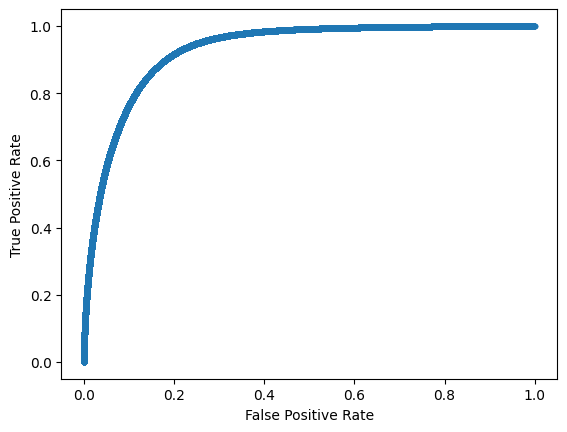

In [47]:
print(f'Validation accuracy is: {accuracy_score(y_test, prediction)}')

# Calculate roc metric 
print('Logistic : ROC AUC = %.3f' % (roc_auc_score(y_test,prediction_probab[:,1])))

fpr,tpr,_ = roc_curve(y_test,prediction_probab[:,1])
plt.plot(fpr,tpr,marker = '.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


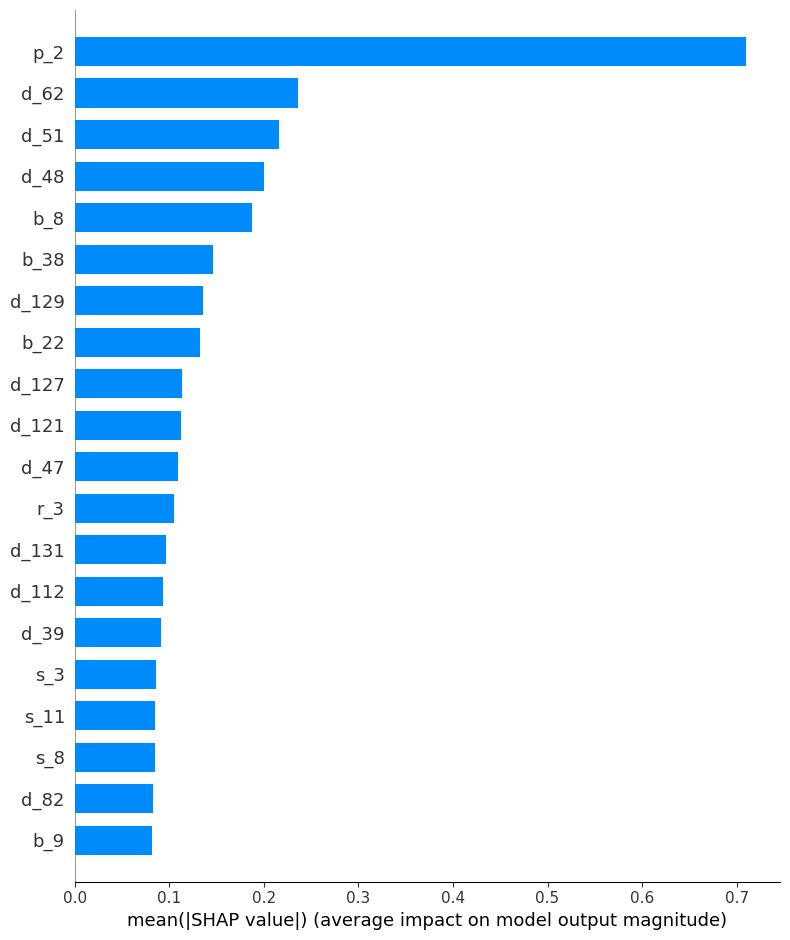

In [52]:
import shap

explainer = shap.LinearExplainer(logit, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)


# Summarize the effect of all the features
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type='bar')

In [53]:
# Generate global shap values and associate with the column
global_shap_values = {k:v for k, v in sorted(zip(X_test.columns, np.abs(shap_values).mean(0)), reverse=True, key=lambda value: value[1])}
print(global_shap_values)

{'p_2': 0.7102979, 'd_62': 0.2357559, 'd_51': 0.21576054, 'd_48': 0.2000793, 'b_8': 0.18756703, 'b_38': 0.14613082, 'd_129': 0.13587761, 'b_22': 0.13274445, 'd_127': 0.1130391, 'd_121': 0.11208408, 'd_47': 0.10961201, 'r_3': 0.1046033, 'd_131': 0.09625509, 'd_112': 0.093951516, 'd_39': 0.09154742, 's_3': 0.08625427, 's_11': 0.08520871, 's_8': 0.08468649, 'd_82': 0.08284594, 'b_9': 0.08236551, 'd_45': 0.0804729, 'd_66': 0.079728544, 'd_70': 0.07755353, 'b_25': 0.07590143, 's_13': 0.070751816, 'd_46': 0.06680596, 'd_114': 0.0658371, 'd_43': 0.05069548, 'd_41': 0.050210528, 'r_27': 0.049562816, 'p_4': 0.04945751, 'b_30': 0.04671756, 'd_80': 0.04548452, 'd_59': 0.044758562, 'p_3': 0.0439018, 'r_1': 0.04291873, 'd_133': 0.04112946, 'd_117': 0.03726835, 'd_124': 0.032604817, 'd_64': 0.032364633, 'd_91': 0.030814193, 'd_122': 0.03039076, 'd_68': 0.030066496, 'd_86': 0.02899027, 'r_11': 0.02817524, 'd_130': 0.026978206, 'd_63': 0.024307523, 'd_52': 0.023417586, 's_7': 0.02340103, 'd_92': 0.022

In [55]:
# Remove features with SHAP less than 0.01
cols_to_remove = [k for k, v in global_shap_values.items() if v < 0.01]

In [56]:
# Model
logit = LogisticRegression(random_state=2303, max_iter=400, solver='sag')
logit.fit(X_train.drop(columns=cols_to_remove),y_train)

LogisticRegression(max_iter=400, random_state=2303, solver='sag')

In [58]:
X_train.drop(columns=cols_to_remove).shape

(4425160, 58)

Validation accuracy is: 0.8652045438315958
Logistic : ROC AUC = 0.928


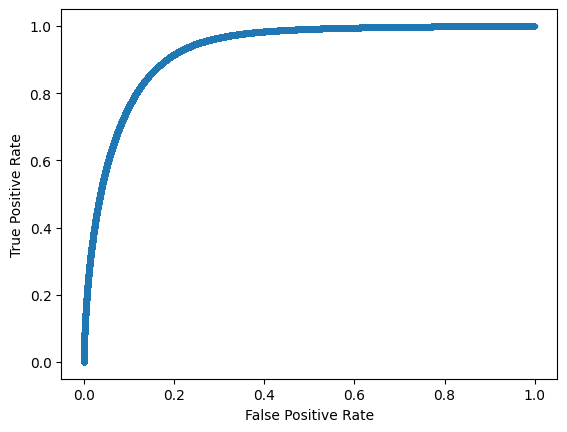

In [57]:
# Calculate the confusion matrix
prediction = logit.predict(X_test.drop(columns=cols_to_remove))
prediction_probab = logit.predict_proba(X_test.drop(columns=cols_to_remove))
confusion_matrix(y_test,prediction)

print(f'Validation accuracy is: {accuracy_score(y_test, prediction)}')

# Calculate roc metric 
print('Logistic : ROC AUC = %.3f' % (roc_auc_score(y_test,prediction_probab[:,1])))

fpr,tpr,_ = roc_curve(y_test,prediction_probab[:,1])
plt.plot(fpr,tpr,marker = '.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [61]:
def execute_model(df):
    # Just add extra columns with 0 value so that pipeline does not fail --> these are the extra columns that we had in the training data
    extra_cols = ['target']
    # Concatenate the dataframe of extra columns with the dataframe of the test data
    df = pd.concat([
        df,
        pd.DataFrame(np.zeros((df.shape[0], len(extra_cols))), columns=extra_cols)
    ], axis=1)

    # Use the pipeline to transform
    X = pipeline.transform(df)

    # Drop target and insignificant variables determined by SHAPly values
    X.drop(columns=['target','customer_id','s_2'] + cols_to_remove, inplace=True)

    return logit.predict_proba(X)[:,1]
    

In [64]:
# del(X, X_test, X_train, y, y_test, y_train)

df_test = pd.read_parquet('../data/test.parquet')
df_test.columns= df_test.columns.str.lower()

# Define the result mdf
mdf = pd.DataFrame(columns=['customer_id', 's_2', 'pred', 'proba'])
y_proba = execute_model(df_test)

mdf = pd.concat([
    mdf,
    pd.DataFrame({
        'customer_id': df_test['customer_id'].values,
        's_2': df_test['s_2'].values,
        'proba': y_proba
    })
]) 
mdf.to_csv('../ignore/final/logistic_pca_shap/intermediate_results.csv', index=False)

In [65]:
mdf['s_2'] = pd.to_datetime(mdf['s_2'])
mdf['s_2'].dtype

dtype('<M8[ns]')

## Just take the last statement probability of each customer

In [66]:
# Get the last statement probability of each of the customer
df_result_last = mdf.sort_values(by = 's_2').groupby('customer_id')[['customer_id','proba']].tail(1)
df_result_last.rename(columns= {'proba' : 'prediction'},inplace=True)
df_result_last.head()
df_result_last.to_csv('../ignore/final/logistic_pca_shap/last_stmt.csv', index=False)

#### Weighted probabilities using Joe's Code (test data) for the last 3 stmts

In [68]:
# Defining the outcome weighting.

def conditions(x):
    # Customer has 3 statements:
    if   x == 3:   return 0.1
    elif x == 6:   return 0.15
    elif x == 9:   return 0.75
    
    # Customer has 2 statements:
    elif x == 2:   return 0.2
    elif x == 4:   return 0.8
    
    # Customer has 1 statement:
    elif x == 1:   return 1.0 
    else:          return "error"

In [69]:
# Take the last 3 statements of each customer
mdf1 = mdf.sort_values('s_2').groupby('customer_id').tail(3)
# if the customer has last 3 stmts the ranking will be as - 1st to the older stmt and 3rd rank to the latest stmt. 
mdf1["statement_num"] = mdf1.groupby("customer_id")["s_2"].rank(method="first", ascending=True)
# The statement_count variable will give the count of the statements for each customer (i.e. to know if they have all the 3 or less than that)
mdf1['statement_count'] = mdf1.groupby('customer_id')['statement_num'].transform('max')

# Create a number so we can handle the case where a customer had only 1 or 2 statements. 
# Multiplied to give me a unique value for each case. See conditions() above.
mdf1['statement_checksum'] = (mdf1['statement_count']) * mdf1['statement_num']

# Assign the weights to the statements
mdf1['statement_weight'] = mdf1['statement_checksum'].apply(conditions)

# Calculating the weighted sum
mdf1 ['prediction'] = mdf1['proba'] * mdf1['statement_weight']

mdf1 = mdf1[['customer_id', 'prediction']]

# Grouping those weighted sums by customer_id to give granularity of 1 proba per customer
mdf1 = mdf1.groupby('customer_id').sum()
# Bring the customer_id from index to column
mdf1.reset_index(inplace=True)
# Send the data to the file
mdf1.to_csv('../ignore/final/logistic_pca_shap/weighted_last3.csv', index=False)